In [57]:
import time
import bz2
import gzip
import json
import pickle
import gc
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, Dataset
from sentence_transformers import (
    SentenceTransformer, 
    SentenceTransformerTrainingArguments,
    SentenceTransformerTrainer
)
from sentence_transformers.losses import SoftmaxLoss
from sentence_transformers.training_args import BatchSamplers

import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments
)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = '/sciclone/data10/twford/reddit/reddit/comments/'
BASE_PATH = '/sciclone/geograd/stmorse/reddit/'

In [4]:
torch.cuda.is_available()

True

# Personality

## Preprocessing data

In [84]:
df = pd.read_csv(f'{BASE_PATH}mbti_data/mbti_full_pull.csv')
df.head()

,author_flair_text,body,subreddit
0,INTJ,Knowing you're in INTJ is a tool for you to us...,intj
1,INTJ,You are truly an enlightened mastermind.,intj
2,"INFJ, 26F",You should :) it will help if you have a down ...,infj
3,INTP,I watch a bit of everything (including hentai)...,INTP
4,INTJ,I don't know if I would count this as a pet pe...,intj


In [85]:
df.shape

(1794016, 3)

In [86]:
mbti_pairs = [('E', 'I'), ('S', 'N'), ('F', 'T'), ('P', 'J')]
mbti_types = []
for k in range(16):
    t = ''
    for i, pair in enumerate(mbti_pairs):
        t += pair[(k >> i) & 1]
    mbti_types.append(t)
print(mbti_types)

['ESFP', 'ISFP', 'ENFP', 'INFP', 'ESTP', 'ISTP', 'ENTP', 'INTP', 'ESFJ', 'ISFJ', 'ENFJ', 'INFJ', 'ESTJ', 'ISTJ', 'ENTJ', 'INTJ']


In [87]:
def find_mbti_type(text):
    for mbti_type in mbti_types:
        if mbti_type.lower() in text.lower():
            return mbti_type
    return None

df['mbti_type'] = df.apply(lambda row: find_mbti_type(row['author_flair_text']) or find_mbti_type(row['subreddit']), axis=1)
df.head()

,author_flair_text,body,subreddit,mbti_type
0,INTJ,Knowing you're in INTJ is a tool for you to us...,intj,INTJ
1,INTJ,You are truly an enlightened mastermind.,intj,INTJ
2,"INFJ, 26F",You should :) it will help if you have a down ...,infj,INFJ
3,INTP,I watch a bit of everything (including hentai)...,INTP,INTP
4,INTJ,I don't know if I would count this as a pet pe...,intj,INTJ


In [88]:
df['mbti_type'].unique()

array(['INTJ', 'INFJ', 'INTP', 'ENTP', 'ENFP', 'ENTJ', 'ISTP', 'ESTP',
       'ISTJ', 'INFP', 'ISFP', 'ENFJ', 'ESTJ', 'ISFJ', 'ESFJ', 'ESFP'],
      dtype=object)

In [89]:
df = (df
      .rename(columns={'body': 'sentence', 'mbti_type': 'label'})
      .drop(columns=['author_flair_text', 'subreddit'])
)

# df['sentence'] = df['sentence'].astype(str)
df['label'] = df['label'].astype(str)

df.head()

,sentence,label
0,Knowing you're in INTJ is a tool for you to us...,INTJ
1,You are truly an enlightened mastermind.,INTJ
2,You should :) it will help if you have a down ...,INFJ
3,I watch a bit of everything (including hentai)...,INTP
4,I don't know if I would count this as a pet pe...,INTJ


In [90]:
# Add label_code column using category codes
df['label_code'] = df['label'].astype('category').cat.codes

# Save the codes to a dictionary
label_code_dict = dict(enumerate(df['label'].astype('category').cat.categories))

print(label_code_dict)
df.head()

{0: 'ENFJ', 1: 'ENFP', 2: 'ENTJ', 3: 'ENTP', 4: 'ESFJ', 5: 'ESFP', 6: 'ESTJ', 7: 'ESTP', 8: 'INFJ', 9: 'INFP', 10: 'INTJ', 11: 'INTP', 12: 'ISFJ', 13: 'ISFP', 14: 'ISTJ', 15: 'ISTP'}


,sentence,label,label_code
0,Knowing you're in INTJ is a tool for you to us...,INTJ,10
1,You are truly an enlightened mastermind.,INTJ,10
2,You should :) it will help if you have a down ...,INFJ,8
3,I watch a bit of everything (including hentai)...,INTP,11
4,I don't know if I would count this as a pet pe...,INTJ,10


In [92]:
with open(f'{BASE_PATH}mbti_data/code_dict.pkl', 'wb') as f:
    pickle.dump(label_code_dict, f)

In [93]:
df = df.drop(columns=['label']).rename(columns={'label_code': 'label'})
df.head()

,sentence,label
0,Knowing you're in INTJ is a tool for you to us...,10
1,You are truly an enlightened mastermind.,10
2,You should :) it will help if you have a down ...,8
3,I watch a bit of everything (including hentai)...,11
4,I don't know if I would count this as a pet pe...,10


In [94]:
# drop na's
df = df.dropna()
df.shape

(1793949, 2)

In [95]:
df.to_csv(f'{BASE_PATH}mbti_data/mbti_clean_v2.csv', index=False, quoting=2)

In [96]:
df.iloc[:1000,:].to_csv(f'{BASE_PATH}mbti_data/little_clean_v2_train.csv', index=False, quoting=2)
df.iloc[1000:1200,:].to_csv(f'{BASE_PATH}mbti_data/little_clean_v2_test.csv', index=False, quoting=2)

## Train model

In [45]:
df_clean = pd.read_csv(f'{BASE_PATH}mbti_data/mbti_clean.csv', 
                       dtype={'sentence': str, 'label': str})
df_clean.shape

(1794016, 2)

In [46]:
df_clean['label'] = df_clean['label'].astype('category').cat.codes
df_clean.head()

,sentence,label
0,Knowing you're in INTJ is a tool for you to us...,10
1,You are truly an enlightened mastermind.,10
2,You should :) it will help if you have a down ...,8
3,I watch a bit of everything (including hentai)...,11
4,I don't know if I would count this as a pet pe...,10


In [63]:
df_clean = df_clean.dropna()
df_clean.shape

(1793949, 2)

In [64]:
df_clean['label'].unique()

array([10,  8, 11,  3,  1,  2, 15,  7, 14,  9, 13,  0,  6, 12,  4,  5],
      dtype=int8)

In [48]:
df_clean['sentence'].dtype

dtype('O')

In [75]:
# dataset = load_dataset('csv', data_files=f'{BASE_PATH}mbti_data/mbti_clean.csv')
train_ds = Dataset.from_pandas(df_clean.iloc[:10000], split='train')
test_ds = Dataset.from_pandas(df_clean.iloc[10000:12000], split='test')

In [27]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [73]:
# Load the tokenizer
# model_name = "distilbert-base-uncased"
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [76]:
def sanitize_text(text):
    # Remove escape characters like \n, \t, etc.
    text = text.replace("\n", " ").replace("\t", " ")
    # Optionally remove non-printable characters
    text = re.sub(r'[^\x20-\x7E]', '', text)
    return text

# Tokenize the data
def preprocess_function(examples):
    # examples["sentence"] = [sanitize_text(sentence) for sentence in examples["sentence"]]
    return tokenizer(examples["sentence"], truncation=True, padding=True)

tokenized_dataset = train_ds.map(preprocess_function, batched=True)
tokenized_test_dataset = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [77]:
# Load the model with a classification head
num_labels = 16 
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",         # Directory to save checkpoints
    # evaluation_strategy="epoch",    # Evaluate at the end of each epoch
    # learning_rate=5e-5,
    # per_device_train_batch_size=16,
    # num_train_epochs=3,
    # weight_decay=0.01,
    # logging_dir="./logs",            # Directory for logs
    # logging_steps=10,
    # save_steps=500,
    # save_total_limit=2,
    # load_best_model_at_end=True,
)

In [81]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [82]:
trainer.train()

Step,Training Loss
500,2.179200
1000,2.091500
1500,1.990300
2000,1.951700
2500,1.937800
3000,1.797800
3500,1.817100


TrainOutput(global_step=3750, training_loss=1.9536769368489584, metrics={'train_runtime': 256.2089, 'train_samples_per_second': 117.092, 'train_steps_per_second': 14.636, 'total_flos': 995471032320000.0, 'train_loss': 1.9536769368489584, 'epoch': 3.0})

In [83]:
trainer.evaluate()

{'eval_loss': 2.038999557495117,
 'eval_accuracy': 0.302,
 'eval_f1': 0.2551153977522228,
 'eval_runtime': 5.583,
 'eval_samples_per_second': 358.23,
 'eval_steps_per_second': 44.779,
 'epoch': 3.0}

### Using SBERT sentence-transformers

In [11]:
model = SentenceTransformer('distilbert-base-uncased',
                            device='cuda')

No sentence-transformers model found with name distilbert-base-uncased. Creating a new one with mean pooling.


In [14]:
# Define the custom loss class
class CrossEntropyLossWithHead(torch.nn.Module):
    def __init__(self, model, num_classes):
        super(CrossEntropyLossWithHead, self).__init__()
        
        # SBERT model
        self.model = model  
        
        # Classification head
        self.classifier = torch.nn.Linear(
            model.get_sentence_embedding_dimension(), 
            num_classes)  
        
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, sentence_features, labels):
        # Compute sentence embeddings
        embeddings = self.model(sentence_features)['sentence_embedding']
        
        # Apply classifier head
        logits = self.classifier(embeddings)
        
        # Compute cross-entropy loss
        return self.loss(logits, labels)

In [15]:
# Define number of MBTI types (16 in this case)
num_classes = 16
# loss = SoftmaxLoss(
#     model=model,
#     sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
#     num_labels=num_classes
# )
loss = CrossEntropyLossWithHead(model, num_classes)

In [ ]:
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [16]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="distilbert-base-personality",
    
    # Optional training parameters:
    num_train_epochs=4,
    per_device_train_batch_size=16,
    # learning_rate=2e-5,
    # warmup_ratio=0.1,
    # fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    # bf16=False,  # Set to True if you have a GPU that supports BF16
    # batch_sampler=BatchSamplers.NO_DUPLICATES,

    # Optional tracking/debugging parameters:
    logging_steps=100,
    run_name="distilbert-base-personality"
)

In [17]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    loss=loss
)

In [18]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: stmorse (stmorse-wm). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befor

TypeError: list indices must be integers or slices, not str

In [ ]:
predictions = []
for sentence in test_sentences:
    embedding = model.encode(sentence)
    predictions.append(model.predict(embedding))  # Or use a classifier layer

print(classification_report(test_labels, predictions))

## Off-the-shelf model

In [2]:
def softmax(logits):
    exp_logits = np.exp(logits) 
    return exp_logits / np.sum(exp_logits)

In [11]:
def personality_detection(text):
    tokenizer = transformers.BertTokenizer.from_pretrained("Minej/bert-base-personality")
    model = transformers.BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.squeeze().detach().numpy()
    
    # convert logit to prob (??)
    # predictions = softmax(predictions)

    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result = {label_names[i]: predictions[i] for i in range(len(label_names))}

    return result

In [13]:
text_input = "Being around people fills me with energy"
personality_prediction = personality_detection(text_input)

print('\n'.join([f'{k}: {v:.2f}' for k,v in personality_prediction.items()]))

Extroversion: -0.13
Neuroticism: 0.28
Agreeableness: -0.23
Conscientiousness: -0.82
Openness: -0.07


In [4]:
personality_detection('This is another really amazing test of this classifier!!')

{'Extroversion': -0.060873274,
 'Neuroticism': 0.13655815,
 'Agreeableness': -0.27149466,
 'Conscientiousness': -0.8811069,
 'Openness': -0.20495062}

# Sentiment embedding

## Clustering sentiment (base) embeddings

In [111]:
# Specify the pre-trained model name or path
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained sentiment classification model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Extract the fine-tuned base model
base_model = model.base_model

def get_sentiment_base_embedding(sentences):
    # Tokenize the input
    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding=True)

    # Get the hidden states from the fine-tuned base model
    with torch.no_grad():
        outputs = base_model(**inputs)
        hidden_states = outputs.last_hidden_state  # Shape: [batch_size, seq_length, hidden_size]

    # mean pooling
    attention_mask = inputs['attention_mask']  # Shape: [batch_size, seq_length]
    sentence_embedding = (hidden_states * attention_mask.unsqueeze(-1)).sum(dim=1) / \
        attention_mask.sum(dim=1, keepdim=True)

    return sentences

In [ ]:
2+2

In [112]:
print('Load sentences')
raw_sentences = utils.load_sentences_bz2(DATA_PATH, 2007, '01')

print('Compute sentiment embeddings')
sentiment_embeddings = get_sentiment_base_embedding(raw_sentences)
sentiment_embeddings.shape

Load sentences
Compute sentiment embeddings


: 

## Comparing sentiment (base) embeddings to original embeddings

In [97]:
# Specify the pre-trained model name or path
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained sentiment classification model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [98]:
# Extract the fine-tuned base model
base_model = model.base_model

In [110]:
# Example sentence
sentence = ["This is a great product!", "What a fantastic model"]

# Tokenize the input
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)

# Get the hidden states from the fine-tuned base model
with torch.no_grad():
    outputs = base_model(**inputs)
    hidden_states = outputs.last_hidden_state  # Shape: [batch_size, seq_length, hidden_size]

# mean pooling
attention_mask = inputs['attention_mask']  # Shape: [batch_size, seq_length]
sentence_embedding = (hidden_states * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

sentence_embedding.shape

torch.Size([2, 768])

In [106]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / \
        torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [101]:
tokenizer_original = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_original = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

In [107]:
inputs_original = tokenizer_original(sentence, return_tensors='pt')

with torch.no_grad():
    outputs_original = model_original(**inputs_original)

# pooling
sentence_embedding_original = mean_pooling(outputs_original, inputs_original['attention_mask'])

sentence_embedding_original.shape

torch.Size([1, 768])

In [108]:
np.linalg.norm(sentence_embedding - sentence_embedding_original)

13.598646

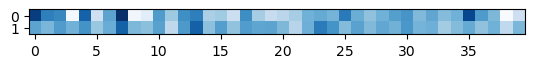

In [109]:
z = np.vstack((sentence_embedding, sentence_embedding_original))

plt.imshow(z[:,:40], cmap='Blues')

## Basic classification of sentiment

In [20]:
classifier = transformers.pipeline(
    'text-classification', 
    model='bhadresh-savani/distilbert-base-uncased-emotion',
    device='cuda',
    top_k=None)

In [26]:
years = [2007]
months = ['01']

labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

for year, month in [(yr, mo) for yr in years for mo in months]:
    embeddings = []
    
    print('Loading sentences...')
    sentences = utils.load_sentences_bz2(DATA_PATH, year, month)

    # crude truncate so we don't exceed max sequence length
    print('Trimming...')
    sentences = [s[:500] for s in sentences]

    print('Computing sentiment...')
    predictions = classifier(sentences)
    
    for p in predictions:
        label_to_score = {entry['label']: entry['score'] for entry in p}
        embeddings.append([label_to_score[label] for label in labels])


Loading sentences...
Trimming...
Computing sentiment...


In [27]:
len(sentences), len(embeddings)

(58954, 58954)

In [32]:
embeddings = np.array(embeddings)

In [33]:
embeddings.shape

(58954, 6)

In [95]:
with open(f'{BASE_PATH}sentiment/sentiment_2007_01.npz', 'wb') as f:
    np.savez_compressed(f, sentiment=embeddings, allow_pickle=False)

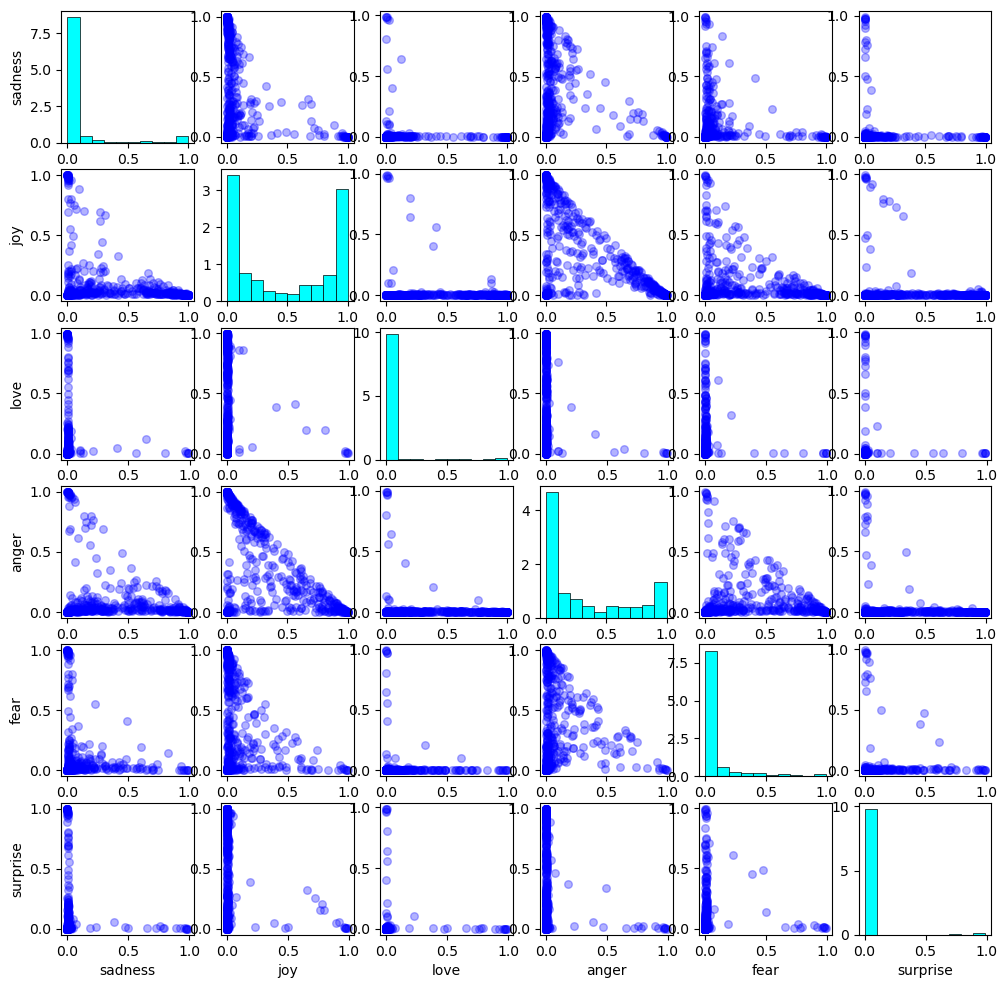

In [50]:
fig, axs = plt.subplots(6,6, figsize=(12,12))

sample_rate = 0.01
L = embeddings.shape[0]
rng = np.random.default_rng(seed=123)
sidx = rng.choice(L, size=int(sample_rate * L), replace=False)

for i, j in [(ii, jj) for ii in range(6) for jj in range(6)]:
    if i==j:
        axs[i,j].hist(embeddings[sidx, i], 
                      density=True, facecolor='cyan', 
                      edgecolor='k', linewidth=0.5)
    else:
        axs[i,j].scatter(embeddings[sidx, i], embeddings[sidx, j], s=30, c='b', alpha=0.3)

    if i==5:
        axs[5,j].set_xlabel(labels[j])
    if j==0:
        axs[i,0].set_ylabel(labels[i])

plt.show()

In [56]:
cluster_centers = utils.load_cc('mbkm_40_2007_td2_cc', base_path=BASE_PATH+'td2/')
num_clusters = cluster_centers.shape[0]
cluster_centers.shape

(40, 384)

In [30]:
topic_embeddings = utils.load_npz(BASE_PATH, 2007, '01', 'embeddings')
topic_embeddings.shape

(58954, 384)

In [60]:
topic_labels = utils.load_npz(BASE_PATH+'td2/', 2007, '01', 'labels')
topic_labels.shape

(58954,)

In [61]:
top_k = 100
closest_idx = np.zeros((num_clusters, top_k))
for i in range(num_clusters):
    idx = np.where(topic_labels==i)[0]
    closest_idx[i,:] = utils.get_closest_vectors_from_subset(
        cluster_centers[i], topic_embeddings, idx, top_k=top_k)

In [62]:
corpus = ['' for _ in range(num_clusters)]
for i in range(num_clusters):
    corpus[i] += ' --- '.join([sentences[int(j)] for j in closest_idx[i,:]])

In [71]:
closest_idx = closest_idx.astype(int)

In [64]:
vectorizer = TfidfVectorizer(
    input='content',
    max_df=0.3,
    # max_features=100,
    use_idf=True,
    smooth_idf=True
)

X = vectorizer.fit_transform(corpus)
print(X.shape)

(40, 13229)


In [65]:
for i in range(X.shape[0]):
    max_idx = np.argsort(X[i,:].toarray().flatten())[::-1][:5]
    keyword = vectorizer.get_feature_names_out()[max_idx]
    # print(f'CLUSTER: {i}\n-----\n')
    # print(corpus[i][:100])
    # print(f'KEYWORD: {keyword}\n-----\n\n')
    print(f'{i}: {keyword}')

0: ['paul' 'ron' 'republican' 'mccain' 'party']
1: ['mart' 'companies' 'wal' 'walmart' 'employees']
2: ['firefox' 'browser' 'linkjacked' 'adblock' 'url']
3: ['child' 'children' 'abortion' 'parents' 'woman']
4: ['haskell' 'languages' 'lisp' 'language' 'python']
5: ['hilarious' 'funniest' 'laugh' 'handicapped' 'humor']
6: ['hello' 'hola' 'sup' 'bäh' 'ni']
7: ['youtube' 'film' 'movie' 'docid' 'videoplay']
8: ['character' 'answers' 'steve' 'style' 'technology']
9: ['cops' 'police' 'crime' 'gun' 'officers']
10: ['racism' 'racist' 'blacks' 'bigotry' 'americans']
11: ['religion' 'atheism' 'religious' 'atheists' 'atheist']
12: ['wealth' 'libertarians' 'trade' 'communism' 'poverty']
13: ['science' 'scientists' 'evidence' 'hominem' 'credibility']
14: ['11' '911' 'conspiracy' 'report' 'plutarch']
15: ['apple' 'price' 'iphone' 'laptop' 'contract']
16: ['7c0' 'photos' 'photo' 'picture' 'pictures']
17: ['warming' 'global' 'co2' 'scientists' 'emissions']
18: ['drink' 'rope' 'acid' 'burn' 'drug']
19: 

In [83]:
t0, t1 = 5, 21
title0, title1 = 'funny', 'israel'

Y = np.vstack((
    topic_embeddings[closest_idx[t0],:],
    topic_embeddings[closest_idx[t1],:]
))

tsne = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=12
)

Yz = tsne.fit_transform(Y)

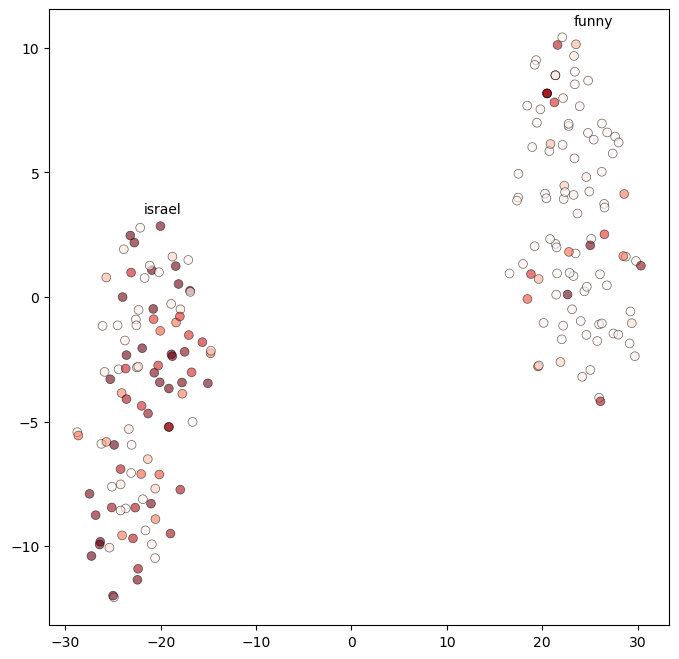

In [94]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

markers = ['o', 'x']

ax.scatter(Yz[:100,0], Yz[:100,1], 
           c=embeddings[closest_idx[t0],3], cmap='Reds',
           edgecolors='k', linewidth=0.5, s=40, alpha=0.6)
ax.text(np.average(Yz[:100,0]), np.amax(Yz[:100,1]) + 0.5, title0)

ax.scatter(Yz[100:,0], Yz[100:,1], 
           c=embeddings[closest_idx[t1],3], cmap='Reds',
           edgecolors='k', linewidth=0.5, s=40, alpha=0.6)
ax.text(np.average(Yz[100:,0]), np.amax(Yz[100:,1]) + 0.5, title1)

plt.show()

In [90]:
embeddings[closest_idx[5,0],:]

array([2.14608503e-03, 1.95369031e-02, 8.41318339e-04, 2.19718996e-03,
       5.53971389e-03, 9.69738781e-01])

## Check correlation between sentiment and topic dimensions

In [5]:
year = 2007
month = '01'

# load sentiment embeddings
print('Load sentiment embeddings...')
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
sentiment_embeddings = utils.load_npz(BASE_PATH, year, month, 'sentiment')

# load topic embeddings
print('Load topic embeddings...')
topic_embeddings = utils.load_npz(BASE_PATH, year, month, 'embeddings')

# load cluster centers
print('Load cluster centers...')
cluster_centers = utils.load_cc('mbkm_40_2007_td2_cc', base_path=BASE_PATH+'td2/')
num_clusters = cluster_centers.shape[0]

# load labels
print('Load topic labels...')
topic_labels = utils.load_npz(BASE_PATH+'td2/', 2007, '01', 'labels')
topic_labels.shape

# load sentences
print('Load sentences...')
sentences = utils.load_sentences_bz2(DATA_PATH, year, month)

# get indices to top sentences for each cluster
top_k = 100
closest_idx = np.zeros((num_clusters, top_k))
for i in range(num_clusters):
    idx = np.where(topic_labels==i)[0]
    closest_idx[i,:] = utils.get_closest_vectors_from_subset(
        cluster_centers[i], topic_embeddings, idx, top_k=top_k)

closest_idx = closest_idx.astype(int)   

# convert to corpus for tf-idf
print('Computing tf-idf...')
corpus = ['' for _ in range(num_clusters)]
for i in range(num_clusters):
    corpus[i] += ' --- '.join([sentences[j] for j in closest_idx[i,:]])

vectorizer = TfidfVectorizer(
    input='content',
    max_df=0.3,
    # max_features=100,
    use_idf=True,
    smooth_idf=True
)

X = vectorizer.fit_transform(corpus)
print(X.shape)

keywords = {}
for i in range(X.shape[0]):
    max_idx = np.argsort(X[i,:].toarray().flatten())[::-1][:5]
    keyword = vectorizer.get_feature_names_out()[max_idx]
    keywords[i] = keyword
    # print(f'{i}: {keyword}')

Load sentiment embeddings...
Load topic embeddings...
Load cluster centers...
Load topic labels...
Load sentences...
Computing tf-idf...
(40, 15478)


In [6]:
# compute covariance between sentiment and topic embeddings

L = sentiment_embeddings.shape[0]

# mean center
mc_se = sentiment_embeddings - np.mean(sentiment_embeddings, axis=0)
mc_te = topic_embeddings - np.mean(topic_embeddings, axis=0)

# compute covariance
cov = (1 / L) * (mc_se.T @ mc_te)
print(cov.shape)

(6, 384)


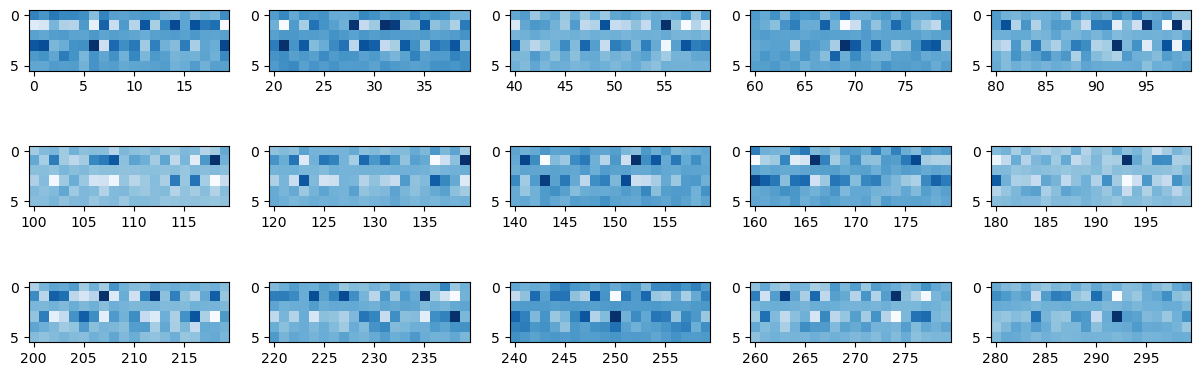

In [7]:
fig, axs = plt.subplots(3, 5, figsize=(15,5))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(cov[:,i*20:(i+1)*20], cmap='Blues')
    ax.set_xticks(range(0, 20, 5))
    ax.set_xticklabels(range(i*20, (i+1)*20, 5))

# plt.colorbar(cb)
plt.show()

In [25]:
sent = 1
sent_args = np.argsort(cov[sent,:])[::-1][:5]
print(sent_args)

emb_idx = np.argsort(topic_embeddings[:,sent_args[0]])[::-1][:10]
print(emb_idx.shape)

[139 300 118 193  55]
(10,)


In [26]:
emb_idx

array([ 1053,  8263, 13265, 52545, 32682,  7528, 48230, 25232, 50716,
       39278])

In [27]:
for i in emb_idx:
    print(sentences[i])

All generalizations are overly broad, including this one, but I don't think that makes them un-useful.
Is there a dedicated user guide to ex anywhere?
&gt; So lecturers began scribbling with the frenetic intensity of battery hens on overtime, producing paper after paper [... ] Little matter if your effort was read only by you and your mates. It was there and it counted.

Does his field (computer "science", as if there is such a thing; it's engineering if you ask me, but I digress) not have journals with impact factors? In biomedical sciences, this is really the only thing that counts. So 1 Nature paper (impact factor 32 or so) is worth around 10 Eur. J. Bioch. (impact factor 3.2 or so) papers. It's not perfect, but it's not so bad either (although it does not account for the 'size' of a field; e.g., the top ecological journal Oikos only has an impact factor of 2.9). It kind of works like an implicit PageRank (with "references" counting as "links").
Article worthless without pix
article

In [18]:
# one hot encoding of topic labels
one_hot_labels = np.zeros((L, num_clusters))
one_hot_labels[np.arange(L), topic_labels] = 1

# Compute the sum of rows in E corresponding to each label
weighted_sum = sentiment_embeddings.T @ one_hot_labels  # (d, k)

# Compute the number of rows corresponding to each label
label_counts = one_hot_labels.sum(axis=0)  # (k,)

# Avoid division by zero
label_counts[label_counts == 0] = 1

# Compute the mean for each label
M = weighted_sum / label_counts  # Broadcasting (d, k)

# normalize each row
M = (M - M.min(axis=1, keepdims=True)) / \
    (M.max(axis=1, keepdims=True) - M.min(axis=1, keepdims=True))

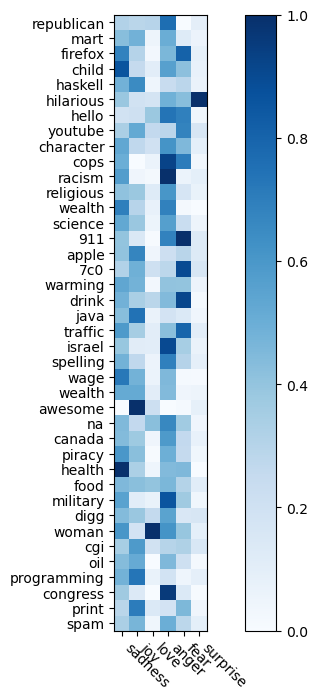

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
cb = ax.imshow(M.T, cmap='Blues')
ax.set_yticks(range(40))
ax.set_yticklabels([keywords[i][0] for i in range(40)])
ax.set_xticks(range(6))
ax.set_xticklabels(labels, rotation=-45, ha='left')
fig.colorbar(cb)
plt.show()

## Tests

In [16]:
sentences = utils.load_sentences_bz2(DATA_PATH, 2007, '01')
len(sentences)

58954

In [17]:
classifier = transformers.pipeline(
    'text-classification', 
    model='bhadresh-savani/distilbert-base-uncased-emotion',
    return_all_scores=True)

/sciclone/home/stmorse/.conda/envs/torch-tik-env/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [18]:
predictions = []
for s in sentences[:10]:
    predictions.append(classifier(s))

In [20]:
predictions[0]

[[{'label': 'sadness', 'score': 0.14320522546768188},
  {'label': 'joy', 'score': 0.6905817985534668},
  {'label': 'love', 'score': 0.0036878613755106926},
  {'label': 'anger', 'score': 0.15312515199184418},
  {'label': 'fear', 'score': 0.007453672122210264},
  {'label': 'surprise', 'score': 0.0019462894415482879}]]

In [21]:
for i in range(5):
    print(sentences[i])
    for entry in predictions[i][0]:
        print(f'{entry['label']}: {entry['score']:.4f}')
    print(f'\n-----\n')

In the city I live in, I probably am.  Might even be the entire island.  Ah well.  It's one thing to know that somewhere, out there over the Internet, there are many like me.  It's another thing to know someone, in my everyday life off the internet, who is like me too.

Pixels on a screen just aren't enough.

Life is a sadness.  But what else can we do but live it?  Life is a happiness.  But what else can we do but endure it?

sadness: 0.1432
joy: 0.6906
love: 0.0037
anger: 0.1531
fear: 0.0075
surprise: 0.0019

-----

Actually, you're incorrect. My post was first, within one minute of the story being posted live on Yahoo!. I did a search on it and also distinctly remember seeing your post with fewer "minutes ago" than mine in the "new" list. 

Regardless, I'm sorry if this was your best post that got buried. It didn't make my top 50 in terms of points for the year anyway.
sadness: 0.7936
joy: 0.0356
love: 0.0013
anger: 0.1653
fear: 0.0032
surprise: 0.0011

-----

Yeah, this was pretty 

In [5]:
model = SentenceTransformer('bhadresh-savani/distilbert-base-uncased-emotion')

No sentence-transformers model found with name bhadresh-savani/distilbert-base-uncased-emotion. Creating a new one with mean pooling.


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
embeddings = model.encode(sentences[:100], show_progress_bar=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
embeddings.shape

(100, 768)